# Simulation #1
This workbook is a first attempt at constructing a simulation of a stochastic dynamical system, with an accompanying estimation of the Perron-Frobenius operator.

In [209]:
using Plots, StatsBase

In [210]:
include("functions.jl");

In [211]:
pyplot();

## Setting up the dynamics
The state space $X$ of our dynamical system will be the flat torus $\mathbb{T}^2$, represented by the square $[0, 2\pi] \times [0, 2\pi]$.

In [212]:
range = 2π;

For most numerical work, we will require a fine reference grid of points.

In [213]:
grid_size = 100;
n_gridpoints = grid_size ^ 2;
grid = creategrid(0, range, grid_size);

### An initial density
We will define an initial uniform density $f_0 (x, y)$ on this state space.

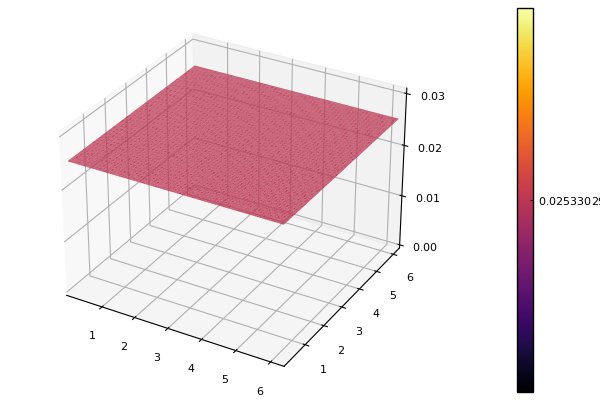

In [214]:
f0s = [f(grid[n,:], range) for n in 1:n_gridpoints];
surface(grid[:,1], grid[:,2], f0s, markersize=1)
zlims!(0, 1.2 * (1/(range^2)))

We also need a sample from this initial density $f_0$.

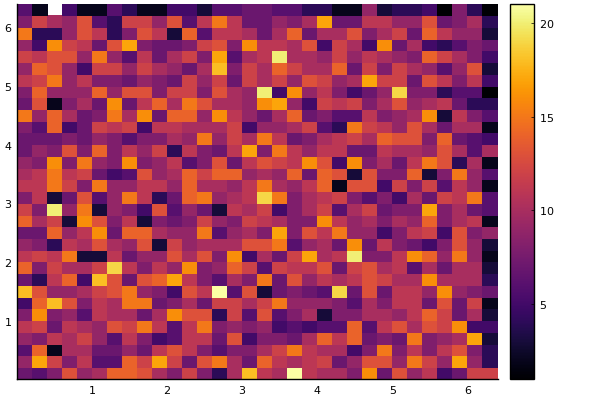

In [215]:
sample_size = 10000;
s = sampledist(sample_size, range);

histogram2d(s[:,1], s[:,2], bins=50)

### A dynamical map
The particular map $S: \mathbb{T}^2 \to \mathbb{T}^2$ chosen to introduce the dynamics is the standard map, or Chirikov–Taylor map, given by
$$
S ([x , y]) := \begin{bmatrix} x + y \\ y + a \sin ( x + y) \end{bmatrix} \mod 2\pi
$$
where $a$ is a parameter which controls the amount of chaos. For the moment we take this to be $a=6$. This map is defined in the function ```S``` which can then be iterated forward across timesteps via ```S_forward```.

We can then easily compare the initial density $f_0$ with a naive estimate of a limiting density $f_*$ by computing the latter with a big value for ```S_forward```.

In [216]:
fstar = S_forward(s, S, 100; map_type="standard");

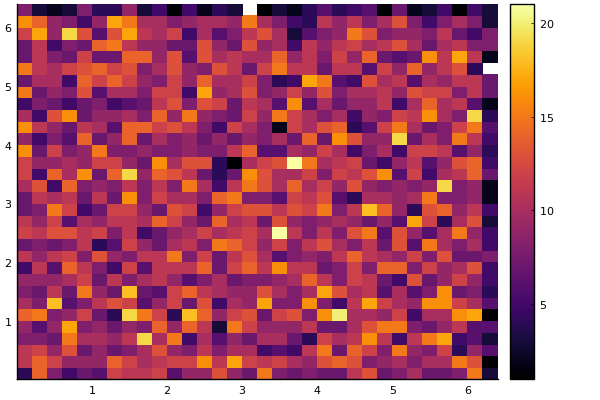

In [217]:
histogram2d(fstar[:,1], fstar[:,2], bins=30)

In this case, the limiting density is precisely the same constant function we started with, so we observe the same distribution `fstar`.

## Estimating the Perron-Frobenius operator
Having established a model for the dynamics, next we want to estimate the Perron-Frobenius operator. 
$$
\mathcal{P} : L^1(X) \to L^1(X)
$$
To do so, we will need to work in a finite-dimensional subspace of $L^1(X)$. And actually. we will be estimating a stochastically perturbed version of $\mathcal{P}$, described by
$$
 \mathcal{L} f(y) = \int_X k(Sx, y ) f(x) dx
$$
where $k(x, y) = \phi(x-y)$. So our goal is an estimation of $\mathcal{L}$, which we will call $L$.

### A finite basis
To compute $L$, we first must define a finite basis for $L^1(X)$. For the moment, we take this basis to be a uniform grid of radial basis functions $\left\{ \varphi_i \right\}_{i=1}^B$. These will be of the form
$$
\varphi_i (x) = \phi ( x - z_i ) := \exp \left( - \frac{\| x - z_i \|^2}{\epsilon^2} \right)
$$
where the $z_i$ denote the centres of each RBF and $\epsilon$ is some bandwidth parameter.

In [218]:
ϵ = 0.55;
c = π * ϵ^2;

In [219]:
basis_grid_size = 40;
n_bases = basis_grid_size ^ 2;
basis_locs = creategrid(0, range, basis_grid_size);

These basis functions can be easily visualised by evaluating all grid points against each.

In [220]:
basis_evaluation_matrix = Array{Float64}(undef, n_gridpoints, n_bases);
for b in 1:n_bases
    for n in 1:n_gridpoints
        basis_evaluation_matrix[n, b] = φ(grid[n, :], basis_locs[b, :], ϵ);
    end
end

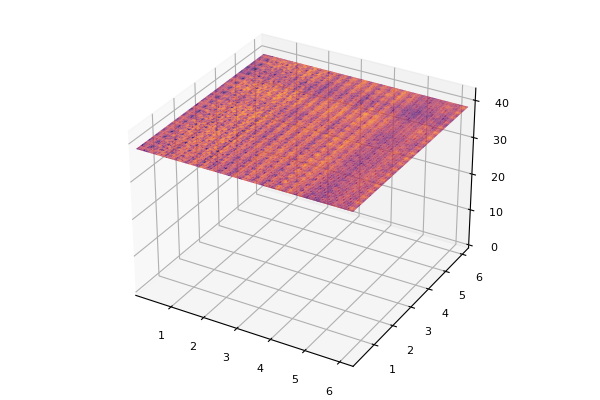

In [221]:
basis_surface = sum(basis_evaluation_matrix, dims=2)[:];
surface(grid[:,1], grid[:,2], basis_surface; legend=false)
zlims!(0,maximum(basis_surface)*1.1)

We get a nice, flat-looking basis surface, which can be used to approximate many functions. Of course, things are not quite so smooth at the local level...

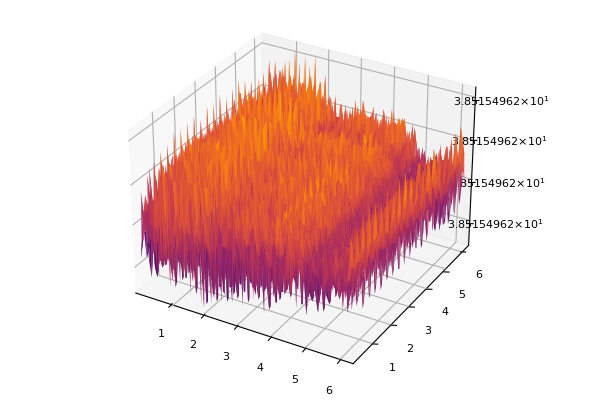

In [222]:
surface(grid[:,1], grid[:,2], basis_surface; legend=false)

In [223]:
println("Average value of basis surface: $(mean(basis_surface))")

Average value of basis surface: 38.515496228238646


### Numerical integrals
In order to estimate the integral
$$
    \mathcal{L} f(y) = \int_X k (Sx, y) f(x) \, \mathrm{d}x ,
$$
we will also need an approximate Lebesgue measure for the integral with respect to $\mathrm{d}x$. This will be some weighted combination of all the datapoints (since they are not uniformly spaced), subject to the constraint that obviously each basis function should integrate to a constant $C$. We can estimate these weights $w$ using nonnegative least squares, though this will first require an evaluation matrix $\Phi$ on the sample according to the basis functions.

In [224]:
Φ = evaluate_phi(s, basis_locs, φ, ϵ);

In [225]:
C = c * ones(n_bases);
x_av = (range^2)/n_bases;

In [226]:
w, residual, objvalue = nnlsq_pen(Φ, C, x_av, 0.01);

Academic license - for non-commercial use only - expires 2021-08-05
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1600 rows, 11600 columns and 11530713 nonzeros
Model fingerprint: 0xde35fc38
Model has 11600 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [5e-04, 5e-04]
  QObjective range [2e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve time: 5.98s
Presolved: 1600 rows, 11600 columns, 11530713 nonzeros
Presolved model has 11600 quadratic objective terms
Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.279e+06
 Factor NZ  : 1.281e+06 (roughly 16 MBytes of memory)
 Factor Ops : 1.367e+09 (roughly 3 seconds per iteration)
 Threads    : 2

  

The weights should sum to a multiple of $(2\pi)^2$, due to the area of the state space.

In [227]:
println("Total sum of weights $(sum(w))")

Total sum of weights 39.478639986412766


We might expect that since the sample points are uniformly distributed, the weights would be almost all equal. This is largely true.

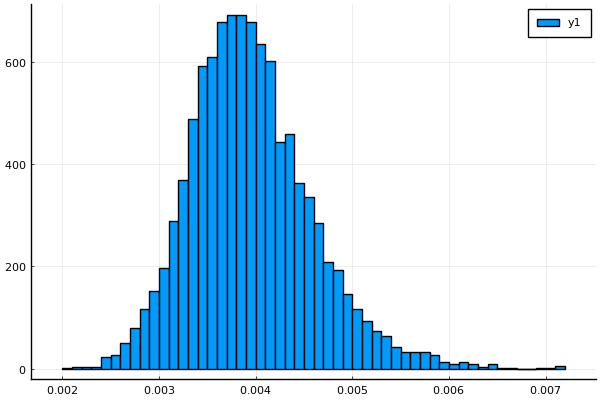

In [228]:
histogram(w)

With these weights, we can now write the image of any basis function $\varphi_i$ under $\mathcal{L}$ as a linear combination of kernels centered at the image points, denoted $\varphi_{y_j}$. But we obviously want to be able to write $\mathcal \varphi_i$ as just a linear combination of the $\varphi_i$. To do this, we will need to write each $\varphi_{y_j}$ itself as a linear combination of the $\varphi_i$.
$$
 \varphi_{y_j} (y) = \sum_{i=1}^m \gamma_i \varphi_i (y)
$$
The weights $\gamma_i$ will be calculated as the integrals of $\varphi_{y_j}$ over a Voronoi tesselation of the basis functions $\varphi_i$, scaled according to weights $c_i = \frac{1}{C}$.

In [229]:
X = s;
Y = S(X; map_type="standard");

In [230]:
Ξ = integrate_phiy(Y, basis_locs, range, 100, ϵ);

This is now everything we need to compute the matrix $L$.

In [231]:
L = construct_L(w, Φ, Ξ, c);

In [232]:
display(L)

1600×1600 Matrix{Float64}:
 0.00171958   0.00281443   0.00304682   …  0.00215138   0.00345074
 0.00158194   0.0025796    0.00277602      0.00195021   0.00316946
 0.00132896   0.0021509    0.00229597      0.00161712   0.00265306
 0.0010249    0.00164051   0.00173399      0.00122639   0.00202222
 0.000734499  0.0011572    0.00120757      0.000855834  0.00140929
 0.000500169  0.000770236  0.000788522  …  0.000558201  0.000908963
 0.000334155  0.00049902   0.000495981     0.000349369  0.00055528
 0.000225932  0.000326086  0.000311503     0.000216621  0.000332076
 0.000156348  0.000219483  0.000201452     0.000136125  0.000200709
 0.000108874  0.000150738  0.000134735     8.66563e-5   0.000124087
 7.38627e-5   0.000102278  9.08089e-5   …  5.46561e-5   7.72179e-5
 4.73645e-5   6.62493e-5   5.94332e-5      3.31543e-5   4.68424e-5
 2.81178e-5   3.99746e-5   3.66497e-5      1.88519e-5   2.68625e-5
 ⋮                                      ⋱               
 2.3787e-5    3.75234e-5   3.93305e-5    

## Checking the results
Now that we have an estimate of $L$, we can start evaluating it.

### Plotting the spectrum
We expect that $L$ should have a leading unit eigenvalue, and all the remaining eigenvalues should have modulus less than one.

In [233]:
λ, Λ = ordered_eigendecomp(L);

In [234]:
display(λ[1])

0.950337359172163 + 0.0im

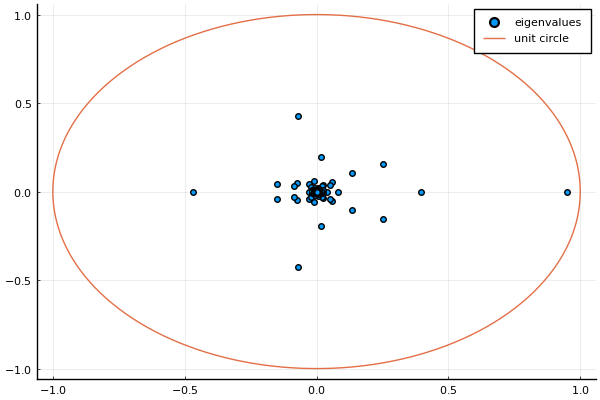

In [235]:
u, v = real.(λ), imag.(λ);
xc, yc = cos.(LinRange(0, 2π, 500)), sin.(LinRange(0, 2π, 500));

scatter(u, v, label="eigenvalues")
plot!(xc, yc, label="unit circle")

### Row stochasticity
We also expect that the estimate should be row-stochastic.

In [236]:
sum(L, dims=2)

1600×1 Matrix{Float64}:
 0.950370769036861
 0.9503514615242558
 0.9502705399876272
 0.9502604257743043
 0.9503583130513303
 0.950413543275078
 0.9503428575007773
 0.9502745268216234
 0.9503167218394385
 0.9503836832966935
 0.9503748778490666
 0.9503377392164
 0.9503378839319587
 ⋮
 0.950431075552365
 0.9503351668101608
 0.9502489398721155
 0.9502907327439984
 0.9503754186922491
 0.9503723507579538
 0.9503167766343237
 0.9503227786033149
 0.9503840429265391
 0.9503997601968168
 0.9503549867630136
 0.9503383990651463

It indeed sums to the same number (which is good) but this number is not one (which is bad). Of course, this number is just the leading eigenvalue.

### Invariant density
We know that the leading eigenvector will specify the linear combination of basis functions which represents the invariant density.

In [237]:
α = real.(Λ[:,1]);

In [238]:
id = basis_combination(grid, basis_locs, φ, ϵ, α);

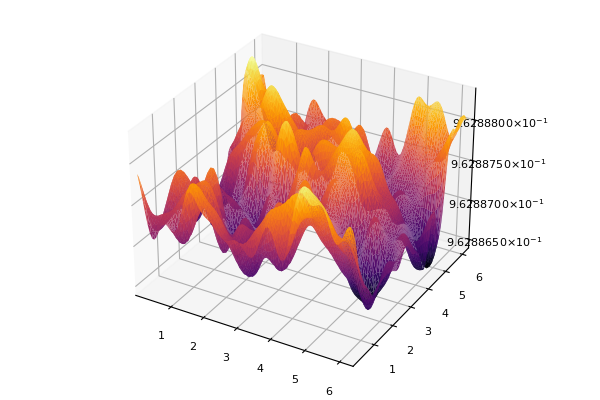

In [239]:
surface(grid[:,1], grid[:,2], id; legend=false)

## Conclusions
We have a reasonably functional procedure. Now it is time to experiment with different model parameters.